In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader
from tqdm import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating

In [ ]:
import os, shutil
import pandas as pd

val_dir = "/content/tiny-imagenet-200/val"
annotations = pd.read_csv(
    os.path.join(val_dir, "val_annotations.txt"),
    sep="\t", header=None, names=["img","label","x1","y1","x2","y2"]
)

for _, row in annotations.iterrows():
    lbl = row["label"]
    lbl_dir = os.path.join(val_dir, lbl)
    os.makedirs(lbl_dir, exist_ok=True)
    shutil.move(os.path.join(val_dir, "images", row["img"]),
                os.path.join(lbl_dir, row["img"]))

# cleanup
shutil.rmtree(os.path.join(val_dir, "images"))
os.remove(os.path.join(val_dir, "val_annotations.txt"))


In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

# --- Config ---
data_dir   = "/content/tiny-imagenet-200"
batch_size = 64
val_pct    = 0.1           # optionally split train → train/val further
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Transforms ---
tsf = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225]),
])

# --- Datasets & Splits ---
full_train = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=tsf)

# Optional: carve out a small val from train
n = len(full_train)
n_val = int(val_pct * n)
n_train = n - n_val
train_ds, extra_val = random_split(full_train, [n_train, n_val],
                                   generator=torch.Generator().manual_seed(42))

# Use the official val set on disk
val_ds_official = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=tsf)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds_official, batch_size=batch_size, shuffle=False, num_workers=4)

# --- Model Setup ---
model = models.resnet18(pretrained=True)       # or resnet50
in_f = model.fc.in_features
model.fc = torch.nn.Linear(in_f, 200)          # 200 Tiny-ImageNet classes
model = model.to(device)

# --- Optimizer & Loss ---
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

In [ ]:
# --- Train Loop (simplest form) ---
best_acc = 0.0
for epoch in range(10):
    # train
    model.train()
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
    scheduler.step()

    # validate
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds==y).sum().item()
            total   += y.size(0)
    acc = correct/total
    print(f"Epoch {epoch+1} Val Acc: {acc:.4f}")
    if acc>best_acc:
        best_acc=acc
        torch.save(model.state_dict(),"best_tiny_imagenet.pth")

print("Done. Best Val Acc:", best_acc)

Epoch 1 Val Acc: 0.4614
Epoch 2 Val Acc: 0.5118
Epoch 3 Val Acc: 0.5266
Epoch 4 Val Acc: 0.5309
Epoch 5 Val Acc: 0.5313
Epoch 6 Val Acc: 0.5409
Epoch 7 Val Acc: 0.5395
Epoch 8 Val Acc: 0.5405
Epoch 9 Val Acc: 0.5390
Epoch 10 Val Acc: 0.5374
Done. Best Val Acc: 0.5409


In [ ]:
# Done. Best Val Acc: 0.5409

In [ ]:
model = models.resnet18(pretrained=False)      # pretrained=False so we don't clobber saved weights
in_f = model.fc.in_features
model.fc = nn.Linear(in_f, 200)               # TINY-IMAGENET has 200 classes
model = model.to(device)

# 2) Load your checkpoint (it might be a dict!)
ckpt = torch.load("best_tiny_imagenet.pth", map_location=device)
if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
    state_dict = ckpt["model_state_dict"]
else:
    state_dict = ckpt

# 4) Finally load—use strict=False if you still have key mismatches:
model.load_state_dict(state_dict, strict=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
def load_resnet18(ckpt_path, device):
    model = models.resnet18(weights=None)      # pretrained=False so we don't clobber saved weights
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, 200)               # TINY-IMAGENET has 200 classes
    model = model.to(device)

    # 2) Load your checkpoint (it might be a dict!)
    ckpt = torch.load(ckpt_path, map_location=device)
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        state_dict = ckpt["model_state_dict"]
    else:
        state_dict = ckpt

    # 4) Finally load—use strict=False if you still have key mismatches:
    model.load_state_dict(state_dict, strict=True)
    return model


In [ ]:
def load_resnet18_for_transfer(ckpt_path, num_classes, device):
    # Step 1: Initialize base model
    model = models.resnet18(weights=None)  # don't use torchvision weights
    model = model.to(device)

    # Step 2: Load checkpoint
    ckpt = torch.load(ckpt_path, map_location=device)
    state_dict = ckpt["model_state_dict"] if "model_state_dict" in ckpt else ckpt

    # Step 3: Remove classifier layer if mismatched
    filtered_state_dict = {
        k: v for k, v in state_dict.items()
        if not k.startswith("fc.")
    }

    model.load_state_dict(filtered_state_dict, strict=False)

    # Step 4: Replace fc layer for new task
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)  # e.g., 200 for TinyImageNet
    model.fc = model.fc.to(device)

    return model

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# (a) Base preprocessing to 64×64 + normalize:
base_tf = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std =[0.229,0.224,0.225]
    ),
])

severity_std = 0.12
gauss_var = (severity_std * 255) ** 2
# (b) Corruption pipeline (here: Gaussian noise + motion blur):
corruption = A.Compose([
    # A.GaussNoise(std_range=(0,0), p=1.0),
    A.GaussNoise(std_range=(severity_std, severity_std), p=1.0),
    # A.MotionBlur(blur_limit=7, p=0.5),
    # A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.3),
    # A.JpegCompression(quality_lower=30, quality_upper=70, p=0.5),
    A.ToFloat(max_value=255.0),
    ToTensorV2(),  # produces a C×H×W tensor in [0..1]
])

class CorruptedTinyImageNet(datasets.ImageFolder):
    def __init__(self, root, base_tf, corruption, **kw):
        super().__init__(root, **kw)
        self.base_tf    = base_tf
        self.corruption = corruption

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)   # img is PIL
        # first apply PIL→Tensor+Normalize
        x = self.base_tf(img)                  # FloatTensor [3,64,64]
        # then corrupt: Albumentations expects H×W×C in [0..255]
        # im_np = (x.permute(1,2,0).numpy() * 255).astype("uint8")
        im_np = np.array(img)
        corr = self.corruption(image=im_np)["image"]
        # corr is already a Tensor [3,64,64] in [0..1]
        # re-normalize after corruption:
        mean = torch.tensor([0.485,0.456,0.406])[:,None,None]
        std  = torch.tensor([0.229,0.224,0.225])[:,None,None]
        corr = (corr - mean) / std
        return corr, label

# build loader
# corrupted_ds = CorruptedTinyImageNet(
#     "/content/tiny-imagenet-200/val",
#     base_tf=base_tf,
#     corruption=corruption
# )
# loader = DataLoader(corrupted_ds, batch_size=64, shuffle=False, num_workers=4)

# # evaluate
# model.eval()
# correct = total = 0
# with torch.no_grad():
#     for x,y in loader:
#         x,y = x.to(device), y.to(device)
#         preds = model(x).argmax(1)
#         correct += (preds==y).sum().item()
#         total   += y.size(0)
# print("Corrupted Val Acc:", correct/total)

In [ ]:
def eval_model_on_corrupted(model):
    corrupted_ds = CorruptedTinyImageNet(
    "/content/tiny-imagenet-200/val",
    base_tf=base_tf,
    corruption=corruption
    )
    loader = DataLoader(corrupted_ds, batch_size=64, shuffle=False, num_workers=2)
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x,y in tqdm(loader):
            x,y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds==y).sum().item()
            total   += y.size(0)
    print("Corrupted Val Acc:", correct/total)

In [ ]:
def fgsm_attack(model, loss_fn, images, labels, eps=0.03):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    images.requires_grad = True

    outputs = model(images)
    loss    = loss_fn(outputs, labels)
    model.zero_grad()
    loss.backward()

    # perturb in gradient sign direction
    grad_sign = images.grad.data.sign()
    adv_images = images + eps * grad_sign
    # print(grad_sign)
    # adv_images = torch.clamp(adv_images, 0.0, 1.0)
    return adv_images

In [ ]:
# eps = 0.001
# model.eval()
# correct = total = 0
# for x,y in val_loader:         # your clean validation loader
#     x,y = x.to(device), y.to(device)
#     adv_x = fgsm_attack(model, nn.CrossEntropyLoss(), x, y, eps=eps)
#     preds = model(adv_x).argmax(1)
#     correct += (preds==y).sum().item()
#     total   += y.size(0)
# print(f"FGSM (ε={eps}) Acc:", correct/total)

FGSM (ε=0.001) Acc: 0.4992


In [ ]:
def eval_model_on_adversarial(model, val_loader, eps=1e-3):
    model.eval()
    correct = total = 0
    for x,y in tqdm(val_loader):         # your clean validation loader
        x,y = x.to(device), y.to(device)
        adv_x = fgsm_attack(model, nn.CrossEntropyLoss(), x, y, eps=eps)
        preds = model(adv_x).argmax(1)
        correct += (preds==y).sum().item()
        total   += y.size(0)
    print(f"FGSM (ε={eps}) Acc:", correct/total)
    return correct/total

In [ ]:
model = load_resnet18("best_tiny_imagenet.pth", device)
eval_model_on_corrupted(model)
eval_model_on_adversarial(model, val_loader, eps=1e-2)

100%|██████████| 157/157 [00:10<00:00, 15.32it/s]

Corrupted Val Acc: 0.265


FGSM (ε=0.01) Acc: 0.2316


In [ ]:
# Corrupted Val Acc: 0.265
# FGSM (ε=0.001) Acc: 0.4992

In [ ]:
model = load_resnet18_for_transfer("resnet18_finetuned_gaussian_sev3.pth", 200, device)
eval_model_on_corrupted(model)
eval_model_on_adversarial(model, val_loader, eps=1e-2)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 157/157 [00:10<00:00, 15.61it/s]

Corrupted Val Acc: 0.0039


FGSM (ε=0.01) Acc: 0.0024


In [ ]:
def set_trainable_params(model, mode="linear"):
    for param in model.parameters():
        param.requires_grad = False

    if mode == "linear":
        for param in model.fc.parameters():
            param.requires_grad = True
        return model, model.fc.parameters()

    elif mode == "partial":
        for name, param in model.named_parameters():
            if name.startswith("layer4") or name.startswith("fc"):
                param.requires_grad = True
        return model, [p for n, p in model.named_parameters() if p.requires_grad]

    elif mode == "full":
        for param in model.parameters():
            param.requires_grad = True
        return model, model.parameters()

    else:
        raise ValueError(f"Unknown fine-tune mode: {mode}")

In [ ]:
def train_model(model, train_loader, val_loader, optimizer):
    best_acc = 0.0
    for epoch in range(10):
        # train
        model.train()
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
        scheduler.step()

        # validate
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                preds = model(x).argmax(1)
                correct += (preds==y).sum().item()
                total   += y.size(0)
        acc = correct/total
        print(f"Epoch {epoch+1} Val Acc: {acc:.4f}")
    return model

In [ ]:
linear_model, trainable_params = set_trainable_params(model, mode="linear")
optimizer = optim.Adam(trainable_params, lr=1e-3)

In [ ]:
linear_model = train_model(linear_model, train_loader, val_loader, optimizer)

In [ ]:
eval_model_on_corrupted(linear_model)
eval_model_on_adversarial(linear_model, val_loader, eps=1e-2)

100%|██████████| 157/157 [00:09<00:00, 15.86it/s]


Corrupted Val Acc: 0.1549
FGSM (ε=0.01) Acc: 0.0995


In [ ]:
full_model, trainable_params = set_trainable_params(model, mode="full")
optimizer = optim.Adam(trainable_params, lr=1e-3)

In [ ]:
full_model = train_model(full_model, train_loader, val_loader, optimizer)

Epoch 1 Val Acc: 0.4145
Epoch 2 Val Acc: 0.4145
Epoch 3 Val Acc: 0.4257
Epoch 4 Val Acc: 0.4147
Epoch 5 Val Acc: 0.4115
Epoch 6 Val Acc: 0.4040
Epoch 7 Val Acc: 0.3970
Epoch 8 Val Acc: 0.4051
Epoch 9 Val Acc: 0.4008
Epoch 10 Val Acc: 0.4012


In [ ]:
eval_model_on_corrupted(full_model)
eval_model_on_adversarial(full_model, val_loader, eps=1e-2)

100%|██████████| 157/157 [00:10<00:00, 14.65it/s]

Corrupted Val Acc: 0.2359


FGSM (ε=0.01) Acc: 0.1894


In [ ]:
partial_model, trainable_params = set_trainable_params(model, mode="partial")
optimizer = optim.Adam(trainable_params, lr=1e-3)

In [ ]:
partial_model = train_model(partial_model, train_loader, val_loader, optimizer)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1 Val Acc: 0.4086
Epoch 2 Val Acc: 0.4097
Epoch 3 Val Acc: 0.4097
Epoch 4 Val Acc: 0.4043
Epoch 5 Val Acc: 0.4098
Epoch 6 Val Acc: 0.4100
Epoch 7 Val Acc: 0.3998
Epoch 8 Val Acc: 0.4082
Epoch 9 Val Acc: 0.4087
Epoch 10 Val Acc: 0.4025


In [ ]:
eval_model_on_corrupted(partial_model)
eval_model_on_adversarial(partial_model, val_loader, eps=1e-2)

100%|██████████| 157/157 [00:10<00:00, 15.18it/s]

Corrupted Val Acc: 0.2338


FGSM (ε=0.01) Acc: 0.1869


In [ ]:
accs = []
transfer_accs = []
epss = [0.5, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for e in epss:
    print(f"Epsilon: {e}")
    acc = eval_model_on_adversarial(model, val_loader, eps=e)
    accs.append(acc)
    acc = eval_model_on_adversarial(full_model, val_loader, eps=e)
    transfer_accs.append(acc)

Epsilon: 0.1


100%|██████████| 157/157 [00:07<00:00, 21.24it/s]


FGSM (ε=0.1) Acc: 0.0115


100%|██████████| 157/157 [00:06<00:00, 25.67it/s]


FGSM (ε=0.1) Acc: 0.0212
Epsilon: 0.01


100%|██████████| 157/157 [00:07<00:00, 21.30it/s]


FGSM (ε=0.01) Acc: 0.2316


100%|██████████| 157/157 [00:06<00:00, 25.80it/s]


FGSM (ε=0.01) Acc: 0.1869
Epsilon: 0.001


100%|██████████| 157/157 [00:08<00:00, 19.02it/s]


FGSM (ε=0.001) Acc: 0.4992


100%|██████████| 157/157 [00:06<00:00, 25.60it/s]


FGSM (ε=0.001) Acc: 0.3736
Epsilon: 0.0001


100%|██████████| 157/157 [00:07<00:00, 20.13it/s]


FGSM (ε=0.0001) Acc: 0.5366


100%|██████████| 157/157 [00:10<00:00, 14.33it/s]


FGSM (ε=0.0001) Acc: 0.3995
Epsilon: 1e-05


100%|██████████| 157/157 [00:06<00:00, 23.96it/s]


FGSM (ε=1e-05) Acc: 0.5405


100%|██████████| 157/157 [00:07<00:00, 22.35it/s]

FGSM (ε=1e-05) Acc: 0.4022


In [ ]:
acc = eval_model_on_adversarial(model, val_loader, eps=0.5)
accs.append(acc)
acc = eval_model_on_adversarial(full_model, val_loader, eps=0.5)
transfer_accs.append(acc)

  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 157/157 [00:07<00:00, 21.67it/s]


FGSM (ε=0.5) Acc: 0.0087


100%|██████████| 157/157 [00:06<00:00, 23.74it/s]

FGSM (ε=0.5) Acc: 0.007


In [ ]:
transfer_accs

[0.0212, 0.1869, 0.3736, 0.3995, 0.4022, 0.007]

In [ ]:
accs = [0.0087, 0.0115, 0.2316, 0.4992, 0.5366, 0.5405]
transfer_accs = [0.007, 0.0212, 0.1869, 0.3736, 0.3995, 0.4022]

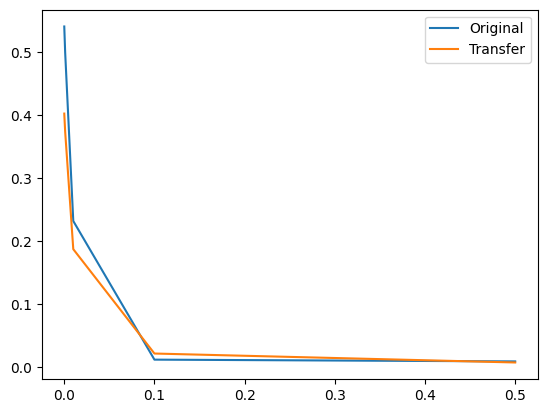

In [ ]:
epss = [0.5, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
plt.plot(epss, accs, label="Original")
plt.plot(epss, transfer_accs, label="Transfer")
plt.legend()
plt.show()

In [ ]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()

#     # Create a temporary directory to save training checkpoints
#     with TemporaryDirectory() as tempdir:
#         best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

#         torch.save(model.state_dict(), best_model_params_path)
#         best_acc = 0.0

#         for epoch in range(num_epochs):
#             print(f'Epoch {epoch}/{num_epochs - 1}')
#             print('-' * 10)

#             # Each epoch has a training and validation phase
#             for phase in ['train', 'val']:
#                 if phase == 'train':
#                     model.train()  # Set model to training mode
#                 else:
#                     model.eval()   # Set model to evaluate mode

#                 running_loss = 0.0
#                 running_corrects = 0

#                 # Iterate over data.
#                 for inputs, labels in dataloaders[phase]:
#                     inputs = inputs.to(device)
#                     labels = labels.to(device)

#                     # zero the parameter gradients
#                     optimizer.zero_grad()

#                     # forward
#                     # track history if only in train
#                     with torch.set_grad_enabled(phase == 'train'):
#                         outputs = model(inputs)
#                         _, preds = torch.max(outputs, 1)
#                         loss = criterion(outputs, labels)

#                         # backward + optimize only if in training phase
#                         if phase == 'train':
#                             loss.backward()
#                             optimizer.step()

#                     # statistics
#                     running_loss += loss.item() * inputs.size(0)
#                     running_corrects += torch.sum(preds == labels.data)
#                 if phase == 'train':
#                     scheduler.step()

#                 epoch_loss = running_loss / dataset_sizes[phase]
#                 epoch_acc = running_corrects.double() / dataset_sizes[phase]

#                 print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#                 # deep copy the model
#                 if phase == 'val' and epoch_acc > best_acc:
#                     best_acc = epoch_acc
#                     torch.save(model.state_dict(), best_model_params_path)

#             print()

#         time_elapsed = time.time() - since
#         print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#         print(f'Best val Acc: {best_acc:4f}')

#         # load best model weights
#         model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
#     return model

In [ ]:
# import torch
# import torchvision.models as models

# # 1. Instantiate your model and load CIFAR-trained weights
# # model = models.resnet50(pretrained=False)        # or resnet18 / densenet121, etc.
# model = models.resnet18(pretrained=True)        # or resnet18 / densenet121, etc.
# n_features = model.fc.in_features
# model.fc = torch.nn.Linear(n_features, 10)       # original CIFAR-10 head
# # model.load_state_dict(torch.load('cifar_finetuned.pt'))
# # model.load_state_dict(torch.load('resnet18_finetuned_gaussian_sev3.pth'))
# print("Loaded CIFAR-trained weights.")

# # 2. Swap in a new head for PACS (7 classes)
# model.fc = torch.nn.Linear(n_features, 7)
# print("Replaced head for PACS (7 classes).")

# # 3. Option A: Freeze backbone, train only the new head
# for name, param in model.named_parameters():
#     if name.startswith('fc.'):
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

# # 3. Option B: Fine-tune entire network (uncomment if you prefer)
# # for param in model.parameters():
# #     param.requires_grad = True

# model = model.to(device)

# # 4. Set up criterion, optimizer, scheduler
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(
#     filter(lambda p: p.requires_grad, model.parameters()),
#     lr=1e-3, momentum=0.9
# )
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# # 5. Call your train loop on PACS dataloaders
# #    Assume `dataloaders` and `dataset_sizes` dicts are already defined for 'train'/'val'
# best_model = train_model(model, criterion, optimizer, scheduler, num_epochs=15)

# # 6. Save your fine-tuned PACS model
# torch.save(best_model.state_dict(), 'resnet50_pacs_finetuned.pt')
# print("PACS fine-tuned model saved.")


In [ ]:
features_list = []

def hook(module, input, output):
    # Flatten output from [B, 512, 1, 1] to [B, 512]
    features_list.append(output.squeeze().detach().cpu())

# Register hook before the final fc
hook_handle = model.avgpool.register_forward_hook(hook)
labels_list = []
model.eval()
for x, y in val_loader:  # val_loader or corrupted_loader
    x = x.to(device)
    with torch.no_grad():
        _ = model(x)  # features will be saved by the hook
    labels_list.extend(y.numpy())

# Concatenate results
import torch
features = torch.cat(features_list, dim=0).numpy()
labels = np.array(labels_list)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
tsne_result = tsne.fit_transform(features)

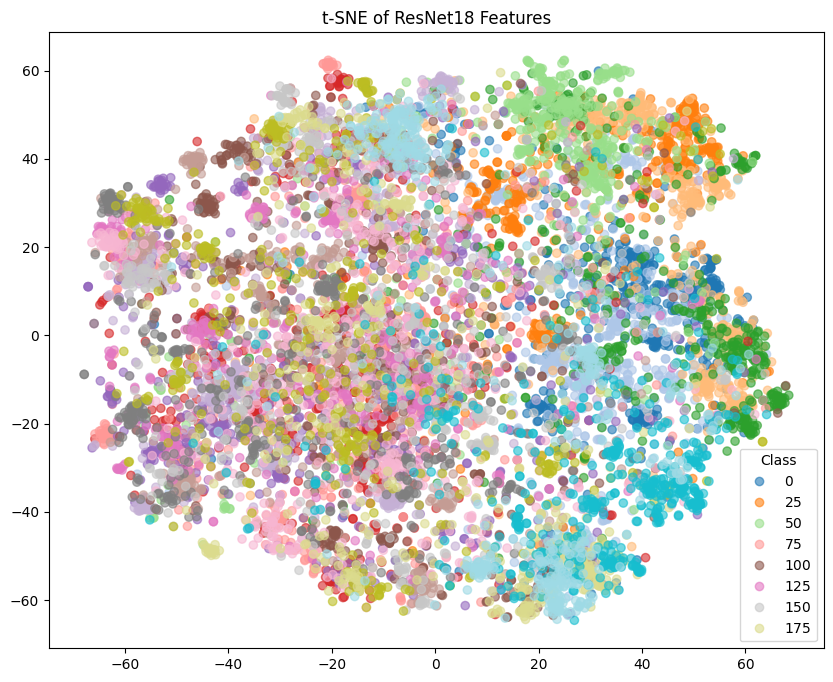

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab20', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Class")
plt.title("t-SNE of ResNet18 Features")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_preds_and_labels(model, loader):
    model.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(y.cpu().numpy())
    return np.array(preds_all), np.array(labels_all)

subset_classes = [5, 7, 13]
preds, labels = get_preds_and_labels(model, val_loader)

mask = np.isin(labels, subset_classes)
filtered_preds  = preds[mask]
filtered_labels = labels[mask]

class_map = {cls: i for i, cls in enumerate(subset_classes)}
mapped_preds  = np.array([class_map[p] for p in filtered_preds if p in class_map])
mapped_labels = np.array([class_map[l] for l in filtered_labels])

cm = confusion_matrix(mapped_labels, mapped_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=subset_classes, yticklabels=subset_classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Subset Classes)")
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


ValueError: Found input variables with inconsistent numbers of samples: [150, 84]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


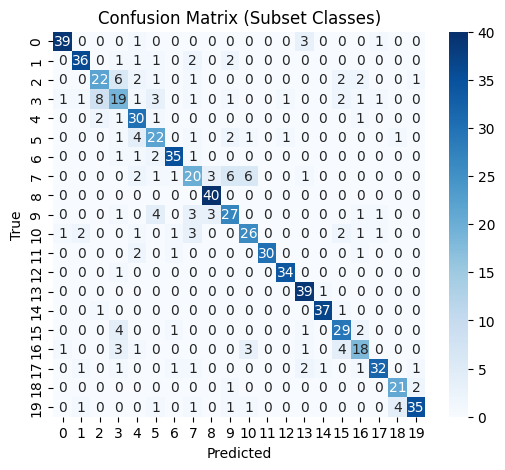

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_preds_and_labels(model, loader):
    model.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(y.cpu().numpy())
    return np.array(preds_all), np.array(labels_all)

subset_classes = range(20)
preds, labels = get_preds_and_labels(model, val_loader)

mask = np.isin(labels, subset_classes)
filtered_preds  = preds[mask]
filtered_labels = labels[mask]

class_map = {cls: i for i, cls in enumerate(subset_classes)}
# Only map predictions that are within the subset_classes
mapped_preds  = np.array([class_map[p] for p in filtered_preds if p in class_map])
mapped_labels = np.array([class_map[l] for l in filtered_labels])

# Filter out labels with no corresponding predictions
mapped_labels = mapped_labels[np.isin(filtered_preds, list(class_map.keys()))]


cm = confusion_matrix(mapped_labels, mapped_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=subset_classes, yticklabels=subset_classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Subset Classes)")
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


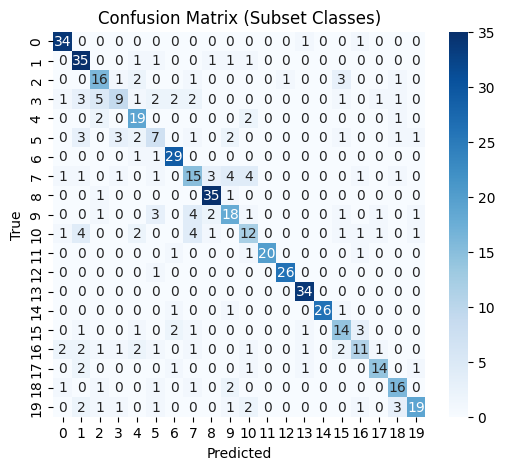

In [ ]:
subset_classes = range(20)
preds, labels = get_preds_and_labels(full_model, val_loader)

mask = np.isin(labels, subset_classes)
filtered_preds  = preds[mask]
filtered_labels = labels[mask]

class_map = {cls: i for i, cls in enumerate(subset_classes)}
# Only map predictions that are within the subset_classes
mapped_preds  = np.array([class_map[p] for p in filtered_preds if p in class_map])
mapped_labels = np.array([class_map[l] for l in filtered_labels])

# Filter out labels with no corresponding predictions
mapped_labels = mapped_labels[np.isin(filtered_preds, list(class_map.keys()))]


cm = confusion_matrix(mapped_labels, mapped_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=subset_classes, yticklabels=subset_classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Subset Classes)")
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Class 131: Recall = 0.1400
Class 175: Recall = 0.1800
Class 132: Recall = 0.2200
Class 139: Recall = 0.2200
Class 159: Recall = 0.2200
Class 168: Recall = 0.2400
Class 27: Recall = 0.2600
Class 48: Recall = 0.2600
Class 197: Recall = 0.2600
Class 158: Recall = 0.2800


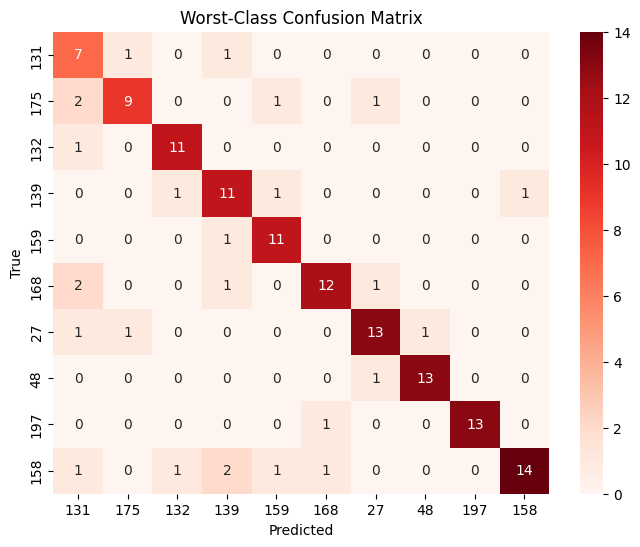

In [ ]:
preds, labels = get_preds_and_labels(model, val_loader)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds, labels=range(200))  # assuming 200 classes
recall_per_class = cm.diagonal() / cm.sum(axis=1)
num_worst = 10  # top 10 worst classes
worst_class_indices = np.argsort(recall_per_class)[:num_worst]
for idx in worst_class_indices:
    print(f"Class {idx}: Recall = {recall_per_class[idx]:.4f}")
worst_cm = cm[np.ix_(worst_class_indices, worst_class_indices)]

plt.figure(figsize=(8,6))
sns.heatmap(worst_cm, annot=True, fmt='d', xticklabels=worst_class_indices, yticklabels=worst_class_indices, cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Worst-Class Confusion Matrix")
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Class 175: Recall = 0.0800
Class 131: Recall = 0.0800
Class 80: Recall = 0.1200
Class 100: Recall = 0.1200
Class 77: Recall = 0.1200
Class 168: Recall = 0.1400
Class 119: Recall = 0.1400
Class 5: Recall = 0.1400
Class 159: Recall = 0.1400
Class 41: Recall = 0.1600


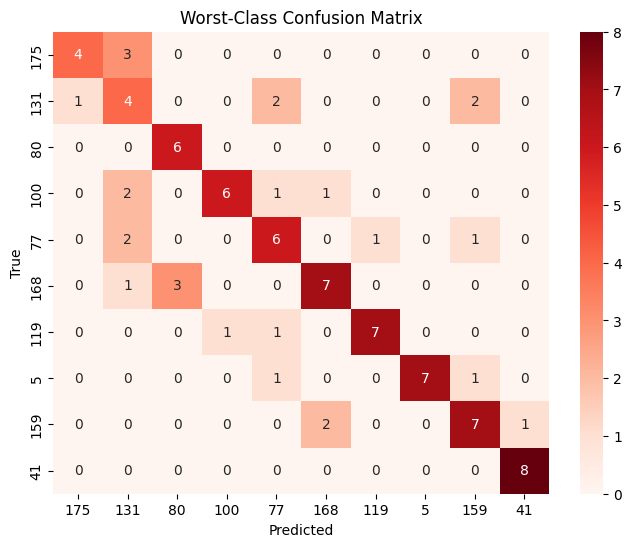

In [ ]:
preds, labels = get_preds_and_labels(full_model, val_loader)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds, labels=range(200))  # assuming 200 classes
recall_per_class = cm.diagonal() / cm.sum(axis=1)
num_worst = 10  # top 10 worst classes
worst_class_indices = np.argsort(recall_per_class)[:num_worst]
for idx in worst_class_indices:
    print(f"Class {idx}: Recall = {recall_per_class[idx]:.4f}")
worst_cm = cm[np.ix_(worst_class_indices, worst_class_indices)]

plt.figure(figsize=(8,6))
sns.heatmap(worst_cm, annot=True, fmt='d', xticklabels=worst_class_indices, yticklabels=worst_class_indices, cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Worst-Class Confusion Matrix")
plt.show()
